# CRI

Corruption risk index will allow us to compare public procurement networks in terms of risky structure.

# CRI

We are going to group by state the following variables:

- Supplier/buyer dispersion
- State-level dispersion
- Proportion of same-state contracts
- Proportion of people suppliers
- Contract daily price
- Contract amount
- File size of the contract
- Proportion of atomized contracts
- Direct award

And compare them to corruption perception in companies and the general population + corruption experience.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx

In [2]:
from sklearn import linear_model
from sklearn import preprocessing
from sklearn.impute import SimpleImputer

In [3]:
corruption = pd.read_csv("../data/states/federal.csv")
# Contracts dataframe
cnts = pd.read_csv("../data/pre-process/contratos_3.csv",
                  parse_dates=["start_date"])
# Select only studied dates
cnts = cnts[(cnts.start_date < '2020-01-01') & (cnts.start_date > '2010-12-31')]
# Three letter state code
codes = pd.read_csv("../data/states/federal.csv",
                   usecols=["state", "code"])
# Some additional data
inegi = pd.read_csv("../data/inegi/state_data.csv")

In [4]:
cnts = pd.merge(cnts,
                codes,
                how="left",
                left_on="buyer_state",
                right_on="state")

cnts = pd.merge(cnts,
                codes,
                how="left",
                left_on="supplier_state",
                right_on="state",
                suffixes=["_b", "_s"])

In [5]:
cnts = cnts[cnts['gvmnt_level'] == 'F']

In [6]:
cnts['code_s'] = cnts['code_s'].fillna("UNK")

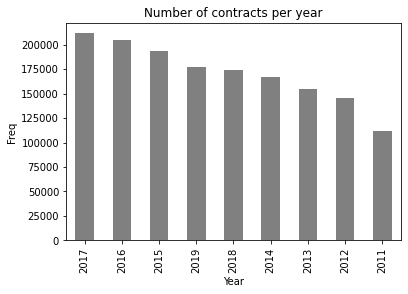

In [7]:
cnts.start_date.dt.year.value_counts().plot(kind="bar", color="gray")
plt.xlabel("Year")
plt.ylabel("Freq")
plt.title("Number of contracts per year");

In [8]:
gb_buyer = cnts.groupby(["code_b"]).code_s.value_counts(normalize=True).rename("Freq").reset_index()

## Corruption

In [9]:
corruption = pd.merge(corruption, codes, how="left")

corruption = corruption.set_index("code")

# INEGI

In [10]:
inegi = pd.merge(inegi, codes, how="left", on="state")

cols_strip = ['population_2015', 'GVA_2011', 'GVA_2012', 'GVA_2013',
       'GVA_2014', 'GVA_2015', 'GVA_2016', 'GVA_2017', 'GVA_2018']

inegi[cols_strip] = inegi[cols_strip].apply(lambda x: x.str.replace(" ", "").astype(float), axis=1)

inegi = inegi.set_index('code')

## Same state contracts, Human suppliers and direct award

- Same state contract: 1 if both supplier and buyer are from the same state, 0 otherwise.
- Human supplier: 1 if the supplier is a person, 0 otherwise
- Direct award: 1 if contract was awarded directly (no competition), 0 otherwise.

In [11]:
cnts['same_state'] = (cnts['code_b'] == cnts['code_s']) * 1

# File size

Number of contracts per file. Each contract has a file and we can know how many contracts were in the file.

We define a file as atomized if its number of contracts is larger than 10.

In [12]:
cnts['atom'] = (cnts['file_size'] > 10) * 1

# Daily price and amount

- Amount: Amount in USD of the contract
- Daily price: Amount divided by time span of contract in days.

# Dispersion

We take the variation coefficient ($\frac{\sigma}{\mu}$) of the distribution contracts of each state to any other state.

Let {20, 30, 30, 20} the distribution of contracts bought by state A.

Then $\sigma = 5$ and $\mu = 25$, therefore $\frac{\sigma}{\mu} = 0.2$.

To finish, we normalize by the number of contracts (100), so dispersion of A in contracts bought is $0.002$.

# Dispersion

In a similar way we compute the dispersion of A in contracts sold.

Two other dispersions are calculated:

- Supplier dispersion (by taking the contract distribution of each supplier)
- Buyer dispersion (by taking the contracts of each buyer)

In total we have 4 dispersion measures.

## Dispersion, Two kinds of risk: public and private. 

Let's work with the two by grouping by `buyer_state` and `supplier_state` at the same time.

## Buyer variation

In [13]:
def var_coeff(states):
    #if np.std(states) == 0:
    #    return np.nan
    
    return np.std(states) / np.mean(states)

In terms of state

In [14]:
bv_s = cnts.groupby('code_b')['code_s'].value_counts().rename('N').reset_index()
bv_s_n = cnts.groupby('code_b').code_s.size().rename('NC').reset_index()
bv_s = bv_s[
    bv_s.code_b != bv_s.code_s].groupby(
    'code_b').N.apply(var_coeff).rename('state_dispersion_b').reset_index()
bv_s = pd.merge(bv_s, bv_s_n, how='left')
bv_s['state_dispersion_b'] = bv_s['state_dispersion_b'] / bv_s['NC']
bv_s = bv_s.drop('NC', axis=1)

In terms of Buyer

In [15]:
bv_b = cnts.groupby(['code_b', 'buyer'])['supplier'].value_counts().rename('N').reset_index()
bv_b_n = cnts.groupby(['code_b', 'buyer']).supplier.size().rename('NC').reset_index()
bv_b = bv_b.groupby(
    ['code_b', 'buyer']).N.apply(var_coeff).rename('buyer_dispersion').reset_index()
bv_b = pd.merge(bv_b, bv_b_n, how='left')
bv_b['buyer_dispersion'] = bv_b['buyer_dispersion']  / bv_b['NC']
bv_b = bv_b.drop('NC', axis=1)

In [16]:
cnts = pd.merge(cnts, bv_s,
                how="left", on="code_b")

In [17]:
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
cnts[['state_dispersion_b']] = imp_mean.fit_transform(cnts[['state_dispersion_b']])

In [18]:
cnts = pd.merge(cnts, bv_b,
                how="left")

In [19]:
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
cnts[['buyer_dispersion']] = imp_mean.fit_transform(cnts[['buyer_dispersion']])

# Supplier variation

In [20]:
sv_s = cnts.groupby('code_s')['code_b'].value_counts().rename('N').reset_index()
sv_s_n = cnts.groupby('code_s').code_b.size().rename('NC').reset_index()
sv_s = sv_s[
    sv_s.code_b != sv_s.code_s].groupby(
    'code_s').N.apply(var_coeff).rename('state_dispersion_s').reset_index()
sv_s = pd.merge(sv_s, sv_s_n, how='left')
sv_s['state_dispersion_s'] = sv_s['state_dispersion_s'] / sv_s['NC']
sv_s = sv_s.drop('NC', axis=1)

In [21]:
sv_s = sv_s.set_index('code_s')

In [22]:
cnts = pd.merge(cnts, sv_s,
                how="left", left_on="code_s", right_index=True)

In [23]:
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
cnts[['state_dispersion_s']] = imp_mean.fit_transform(cnts[['state_dispersion_s']])

In [24]:
# Get distribution of contracts per supplier
sv_b = cnts.groupby(['code_s', 'supplier'])['buyer'].value_counts().rename('N').reset_index()
sv_b_n = cnts.groupby(['code_s', 'supplier']).buyer.size().rename('NC').reset_index()
sv_b = sv_b.groupby(
    ['code_s', 'supplier']).N.apply(var_coeff).rename('supplier_dispersion').reset_index()
sv_b = pd.merge(sv_b, sv_b_n, how='left')
sv_b['supplier_dispersion'] = sv_b['supplier_dispersion']   / sv_b['NC']
sv_b = sv_b.drop('NC', axis=1)

In [25]:
cnts = pd.merge(cnts, sv_b,
                how="left")

In [26]:
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
cnts[['supplier_dispersion']] = imp_mean.fit_transform(cnts[['supplier_dispersion']])

# Buyer clustering

In [27]:
G = nx.from_pandas_edgelist(cnts,
                            source="buyer",
                            target="supplier")

In [28]:
buyers = cnts.buyer.unique()

In [29]:
c_nodes = nx.bipartite.clustering(G, nodes=buyers)

In [30]:
c_nodes = [[k, c_nodes[k]] for k in c_nodes]

In [31]:
cluster = pd.DataFrame(c_nodes, columns=['buyer', 'clustering'])

In [32]:
cnts = pd.merge(cnts,
         cluster,
         how='left',
         on='buyer')

## Put it all together in a linear model

In [33]:
# When we consider all together we have 11 co-variates.

covariates = ['same_state',
              'person',
              'single_bid',
              'state_dispersion_b',
              'buyer_dispersion',
              'state_dispersion_s',
              'supplier_dispersion',
              #'clustering',
              'daily_price',
              'amount',
              'file_size',
              'atom']

In [34]:
cnts_train = cnts.copy()

In [35]:
ss = cnts_train.groupby("code_b", as_index=False)[['same_state', 'person', 'single_bid']].mean()

ss = pd.merge(ss,
             inegi[["population_2015", "GVA_2015"]],
             left_on="code_b",
             right_index=True)

ss = pd.merge(ss,
              corruption[["very_high_r", "c_very_high_r", "e_exp_r"]],
              how="left",
              left_on="code_b",
              right_index=True)

ss['gva_pc'] = ss['GVA_2015'] / ss['population_2015']

cl = cnts_train.groupby("code_b", as_index=False)[["clustering"]].mean()

sd = cnts_train.groupby("code_b", as_index=False)[["supplier_dispersion"]].mean()

bd = cnts_train.groupby("code_b", as_index=False)[["buyer_dispersion"]].mean()

dp = cnts_train.groupby("code_b", as_index=False)[["daily_price", "amount"]].mean()

fs = cnts_train.groupby("code_b", as_index=False)[['file_size', 'atom']].mean()

In [36]:
gb = pd.merge(ss, bv_s)
gb = pd.merge(gb, bd)
gb = pd.merge(gb, sv_s, left_on="code_b", right_index=True)
gb = pd.merge(gb, sd)
gb = pd.merge(gb, dp)
gb = pd.merge(gb, fs)
gb = pd.merge(gb, cl)

In [37]:
# We fit it in a linear model

X = gb[covariates].values
# Scale the features to range [0,1]
min_max_scaler = preprocessing.MinMaxScaler()
#X = min_max_scaler.fit_transform(X)

y = gb['very_high_r'].values

ols = linear_model.LinearRegression()
ols.fit(X, y)

#X_test = min_max_scaler.transform(cnts[covariates].values)
#cnts['CRI'] = np.inner(X_test, ols.coef_) + ols.intercept_
cnts['CRI'] = np.inner(cnts[covariates].values, ols.coef_) + ols.intercept_

cri = cnts.groupby('code_b', as_index=False).CRI.mean()

gb['CRI'] = np.inner(X, ols.coef_) + ols.intercept_

gb = gb.drop('CRI', axis=1)

gb = pd.merge(gb, cri, how='left')

In [38]:
gb.corr(method='spearman')

,same_state,person,single_bid,population_2015,GVA_2015,very_high_r,c_very_high_r,e_exp_r,gva_pc,state_dispersion_b,buyer_dispersion,state_dispersion_s,supplier_dispersion,daily_price,amount,file_size,atom,clustering,CRI
same_state,1.000000,0.277126,-0.153959,0.309018,0.245968,0.153621,0.413123,-0.023094,0.135630,-0.161290,0.279692,-0.283358,0.326613,-0.218109,0.213710,-0.272361,-0.261364,0.065982,0.313783
person,0.277126,1.000000,-0.087977,-0.292155,-0.254765,0.119157,0.103372,0.010264,-0.004032,0.190982,0.193182,0.295455,0.285191,-0.171188,0.168255,-0.431085,-0.367302,-0.296921,0.174487
single_bid,-0.153959,-0.087977,1.000000,0.188050,0.322947,0.149771,0.062683,-0.011730,0.292522,-0.623534,-0.788490,-0.497067,-0.395528,0.021628,-0.356672,0.315249,0.096408,-0.487903,0.307551
population_2015,0.309018,-0.292155,0.188050,1.000000,0.747801,0.545921,0.592375,0.082478,-0.233871,-0.742302,-0.441716,-0.784091,0.009531,0.181818,0.109971,0.243035,0.134897,-0.087243,0.464809
GVA_2015,0.245968,-0.254765,0.322947,0.747801,1.000000,0.324290,0.491935,0.079179,0.362170,-0.729472,-0.373900,-0.821848,-0.061584,0.061217,0.072947,0.281525,0.065982,-0.153226,0.298754
very_high_r,0.153621,0.119157,0.149771,0.545921,0.324290,1.000000,0.726856,0.352521,-0.236480,-0.426214,-0.377819,-0.421448,-0.171402,0.091476,0.246563,0.234280,0.208433,-0.106508,0.547754
c_very_high_r,0.413123,0.103372,0.062683,0.592375,0.491935,0.726856,1.000000,0.334677,-0.015029,-0.504399,-0.254765,-0.493768,-0.017962,0.051686,0.268695,0.133065,0.095674,-0.202713,0.627566
e_exp_r,-0.023094,0.010264,-0.011730,0.082478,0.079179,0.352521,0.334677,1.000000,0.105938,-0.071848,-0.197947,-0.144062,-0.130865,0.002933,0.311217,0.204179,0.109238,-0.325513,0.418622
gva_pc,0.135630,-0.004032,0.292522,-0.233871,0.362170,-0.236480,-0.015029,0.105938,1.000000,-0.135997,-0.028592,-0.190616,-0.265396,-0.189150,-0.045821,0.185484,-0.007331,-0.131965,0.013930
state_dispersion_b,-0.161290,0.190982,-0.623534,-0.742302,-0.729472,-0.426214,-0.504399,-0.071848,-0.135997,1.000000,0.765762,0.862903,0.287757,-0.127199,0.064150,-0.276026,-0.082845,0.291056,-0.629765


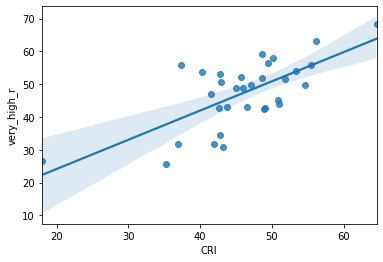

In [39]:
sns.regplot(x='CRI', y='very_high_r', data=gb)

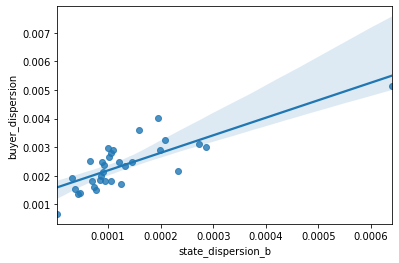

In [40]:
sns.regplot(x="state_dispersion_b", y="buyer_dispersion", data=gb)

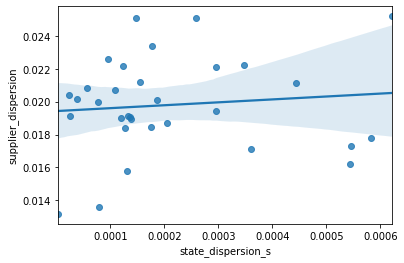

In [41]:
sns.regplot(x="state_dispersion_s", y="supplier_dispersion", data=gb)

In [43]:
cnts.to_csv("../data/pre-process/contratos_4.csv", index=False)

# Future work

In no particular order:

- Federal government changes ( $2012-2013, 2018-2019$ )
- State party changes in government (Veracruz, Quintana-Roo)
- Network differences by type of contract (e.g. Energy vs Education) 